In [1]:
import numpy as np
import pandas as pd
import ms_feature_validation as mfv
import bokeh.plotting
bokeh.plotting.output_notebook()
import matplotlib.pyplot as plt

Loading BokehJS ...

In [2]:
data = mfv.fileio.read_progenesis("../examples/SuerosRCC_ESi_neg_default_SepOct2017.csv")

# adding order and batch information
temp = pd.Series(data=data.sample_metadata.index.str.split("_"),
                 index=data.sample_metadata.index)
order = temp.apply(lambda x: x[-1]).astype(int)
dates = temp.apply(lambda x: x[1])
dates_to_batch = dict(zip(dates.unique(), range(1, dates.size + 1)))
batch = (temp.apply(lambda x: dates_to_batch[x[1]])).astype(int)

def convert_to_global_run_order(order, batch):
    max_order = order.groupby(batch).max()
    max_order[0] = 0
    max_order = max_order.sort_index()
    max_order = max_order.cumsum()
    global_run_order = order + batch.apply(lambda x: max_order[x - 1])
    return global_run_order

data.order = convert_to_global_run_order(order, batch)
data.batch = batch
data.id = data.sample_metadata.index

# setup sample types
sample_mapping = {"qc": ["QC"],
                  "blank": ["SV"],
                  "sample": ["CS", "EI", "EII", "EIII", "EIV", "EI2", "EII2",
                             "EIII2", "EIV2", "Crb", "Pa", "QC"]}
data.mapping = sample_mapping

In [3]:
cr = mfv.filter.ClassRemover(["Sarc", "B", "O", "Onc", "EII2", "Pa"])
pf = mfv.filter.PrevalenceFilter(lb=0.8)
vf = mfv.filter.VariationFilter(ub=0.25)
pipeline = mfv.filter.Pipeline([cr, pf, vf], verbose=True)
pipeline.process(data)
rm_cols = data.data_matrix.columns.difference(data.data_matrix.columns[300:600])
data.remove(rm_cols, axis="features") 
data.sample_metadata = data.sample_metadata.sort_values("order")
data.data_matrix = data.data_matrix.loc[data.sample_metadata.index, :]

# batch_checker = mfv.filter.BatchSchemeChecker()
# batch_checker.process(data)
# batch_prevalence = mfv.filter.BatchPrevalenceChecker()
# batch_prevalence.process(data)

Applying Class Remover: 0 features removed, 28 samples removed, Mean CV reduced by 2.19 %.
Applying Prevalence Filter: 696 features removed, 0 samples removed, Mean CV reduced by 33.53 %.
Applying Variation Filter: 8707 features removed, 0 samples removed, Mean CV reduced by -11.09 %.


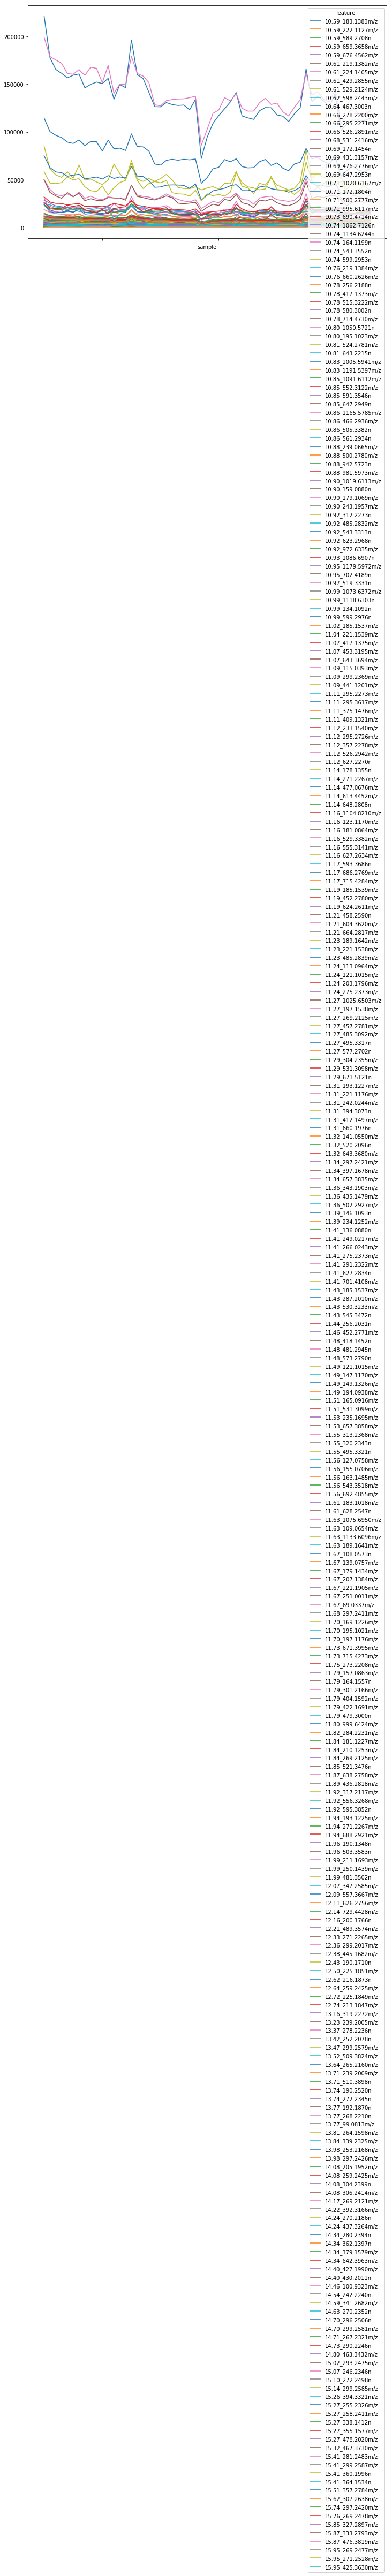

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
data.data_matrix[data.classes == "QC"].plot(ax=ax)

In [8]:
batch_corrector = mfv.filter.BatchCorrector(n_min=4)
batch_corrector.process(data)
bc = mfv.filter.BlankCorrector()
bc.process(data)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
data.data_matrix[data.classes == "QC"].plot(ax=ax)

In [7]:
data.data_matrix[data.classes == "QC"].mean()

feature
10.05_488.2956m/z     778.044952
10.05_522.3099m/z      44.890916
10.05_526.3126m/z     550.075885
10.05_584.2310m/z     595.877078
10.05_587.2191m/z    1215.902150
10.06_476.3473n       465.243540
10.06_483.2968m/z       8.502831
10.08_213.1496m/z      84.184601
10.10_392.2915n      3018.122243
10.12_487.3276m/z     304.777266
10.13_243.1950m/z      12.440194
10.13_578.3638n       606.746490
10.17_600.3334m/z     209.827586
10.17_658.2474m/z     213.506208
10.18_146.1098n        62.660156
10.18_275.1647m/z      55.345712
10.18_415.2686m/z     407.691835
dtype: float64

In [10]:
data.plot.pca_scores(color_by="type", scatter_params={"size": 7}, scaling=None);

In [21]:
data.data_matrix[data.classes == "QC"].groupby(data.batch).mean()

feature,0.04_232.9746m/z,0.12_210.9040m/z,0.41_382.8852m/z,0.59_382.8853m/z,0.72_236.9705m/z,0.92_632.2048m/z,0.94_130.8884m/z,0.94_139.0295n,0.94_212.0196m/z,0.94_318.9559m/z,...,9.91_193.1230m/z,9.91_229.1797m/z,9.91_393.1010m/z,9.93_134.1532n,9.93_336.2292n,9.94_466.3507n,9.94_519.2938m/z,9.94_573.2009m/z,9.96_485.3001m/z,9.96_610.3692n
batch,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,35.663443,9.962467,29.697723,7.826566,8.358022,...,91.282388,32.699588,0.0,512.587201,213.791528,311.415332,25.146819,273.309729,0.0,430.404460
2,0.0,0.0,0.0,0.0,0.0,35.123225,11.193012,31.620419,8.357874,6.838630,...,79.893668,33.279336,0.0,432.206644,309.930088,283.973214,26.147798,231.815791,0.0,349.329083
6,0.0,0.0,0.0,0.0,0.0,54.485592,9.404543,32.940861,11.960981,6.465448,...,82.202821,22.717083,0.0,473.598498,78.639299,187.824382,36.000065,170.825039,0.0,371.829024
7,0.0,0.0,0.0,0.0,0.0,48.788562,11.897862,35.629802,15.084781,7.265078,...,66.268790,25.322524,0.0,433.731344,245.159064,197.850151,37.696171,207.925839,0.0,418.528788
8,0.0,0.0,0.0,0.0,0.0,42.734686,12.968012,34.082372,12.761249,7.538118,...,84.540242,15.612913,0.0,521.235725,369.056884,227.550263,36.392677,147.797523,0.0,270.892043
9,0.0,0.0,0.0,0.0,0.0,57.483492,12.169314,37.646589,17.802010,9.335339,...,76.580035,5.360253,0.0,483.429973,44.481432,244.121421,32.724571,171.380534,0.0,291.552461
10,0.0,0.0,0.0,0.0,0.0,31.576201,10.704036,35.432002,18.411163,7.361034,...,48.455781,21.177488,0.0,495.453879,278.747035,245.758229,35.917565,203.156617,0.0,376.463183
11,0.0,0.0,0.0,0.0,0.0,52.567889,11.112649,36.249301,14.746604,8.993917,...,48.744278,3.144371,0.0,402.841589,0.000000,175.591072,34.489416,105.279027,0.0,290.617829


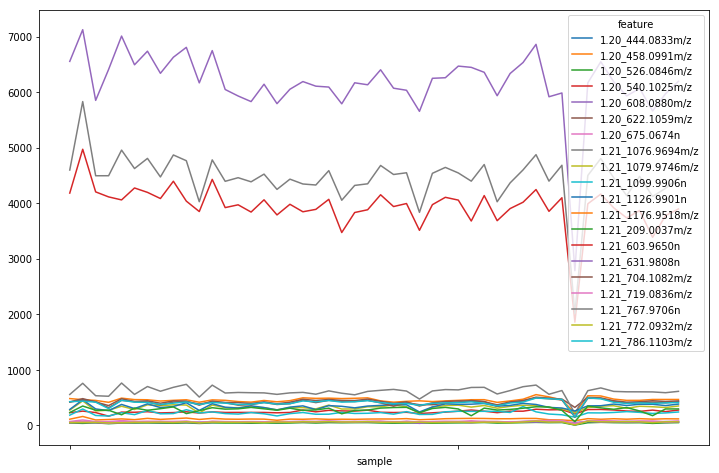

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
data.data_matrix.loc[data.classes == "QC", data.data_matrix.columns[100:120]].plot(ax=ax)

In [13]:
a = data.data_matrix
b = (a - a.mean()) / a.std()

In [6]:
data.preprocess.normalize("max", inplace=False).max(axis=1)

sample
NZ_20170921_RCC_005    1.0
NZ_20170921_RCC_007    1.0
NZ_20170921_RCC_009    1.0
NZ_20170921_RCC_011    1.0
NZ_20170921_RCC_013    1.0
NZ_20170921_RCC_019    1.0
NZ_20170921_RCC_021    1.0
NZ_20170921_RCC_023    1.0
NZ_20170921_RCC_025    1.0
NZ_20170921_RCC_027    1.0
NZ_20170921_RCC_031    1.0
NZ_20170921_RCC_033    1.0
NZ_20170921_RCC_035    1.0
NZ_20170921_RCC_037    1.0
NZ_20170921_RCC_041    1.0
NZ_20170921_RCC_043    1.0
NZ_20170921_RCC_045    1.0
NZ_20170921_RCC_047    1.0
NZ_20170921_RCC_049    1.0
NZ_20170921_RCC_051    1.0
NZ_20170921_RCC_053    1.0
NZ_20170921_RCC_055    1.0
NZ_20170921_RCC_057    1.0
NZ_20170921_RCC_059    1.0
NZ_20170921_RCC_061    1.0
NZ_20170921_RCC_063    1.0
NZ_20170921_RCC_065    1.0
NZ_20170921_RCC_067    1.0
NZ_20170921_RCC_069    1.0
NZ_20170921_RCC_071    1.0
                      ... 
NZ_20171006_RCC_017    1.0
NZ_20171006_RCC_019    1.0
NZ_20171006_RCC_023    1.0
NZ_20171006_RCC_027    1.0
NZ_20171006_RCC_029    1.0
NZ_20171006_RCC_031  

In [23]:
data.data_matrix.divide(data.data_matrix.sum(axis=1), axis=0).sum(axis=1)

sample
NZ_20170921_RCC_005    1.0
NZ_20170921_RCC_007    1.0
NZ_20170921_RCC_009    1.0
NZ_20170921_RCC_011    1.0
NZ_20170921_RCC_013    1.0
NZ_20170921_RCC_019    1.0
NZ_20170921_RCC_021    1.0
NZ_20170921_RCC_023    1.0
NZ_20170921_RCC_025    1.0
NZ_20170921_RCC_027    1.0
NZ_20170921_RCC_031    1.0
NZ_20170921_RCC_033    1.0
NZ_20170921_RCC_035    1.0
NZ_20170921_RCC_037    1.0
NZ_20170921_RCC_041    1.0
NZ_20170921_RCC_043    1.0
NZ_20170921_RCC_045    1.0
NZ_20170921_RCC_047    1.0
NZ_20170921_RCC_049    1.0
NZ_20170921_RCC_051    1.0
NZ_20170921_RCC_053    1.0
NZ_20170921_RCC_055    1.0
NZ_20170921_RCC_057    1.0
NZ_20170921_RCC_059    1.0
NZ_20170921_RCC_061    1.0
NZ_20170921_RCC_063    1.0
NZ_20170921_RCC_065    1.0
NZ_20170921_RCC_067    1.0
NZ_20170921_RCC_069    1.0
NZ_20170921_RCC_071    1.0
                      ... 
NZ_20171006_RCC_017    1.0
NZ_20171006_RCC_019    1.0
NZ_20171006_RCC_023    1.0
NZ_20171006_RCC_027    1.0
NZ_20171006_RCC_029    1.0
NZ_20171006_RCC_031  